# GradientBoosting

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

## Read dataset

In [2]:
data_train = pd.read_csv('processed_training.csv')
data_test = pd.read_csv('processed_test.csv')
data_train.head()

,attendance,is_federal_holiday,venue,on_grass,temperature,wind_speed,team1_name,team1_pre_win,team1_pre_loss,team1_pre_win_pct,...,weather_Rain,weather_Sunny,season_type,season,home_team_avg_att_last_year,start_hour,start_hour_label_afternoon,start_hour_label_evening,start_hour_label_night,start_hour_label_noon
0,35055,0,Wrigley Field,1,-2.786672,-0.093090,STL,-1.62645,-1.654514,0.0,...,0,1,regular,2015,0.345307,19,0,1,0,0
1,49043,0,Chase Field,1,0.705205,-0.093090,SFG,-1.62645,-1.654514,0.0,...,0,1,regular,2015,-0.573314,19,0,1,0,0
2,43633,0,Great American Ball Park,1,-0.521670,1.490839,PIT,-1.62645,-1.654514,0.0,...,0,0,regular,2015,0.066649,16,1,0,0,0
3,45030,0,Comerica Park,1,-2.031671,-0.489072,MIN,-1.62645,-1.654514,0.0,...,0,0,regular,2015,0.766348,13,0,0,0,1
4,43753,0,Minute Maid Park,1,0.516455,1.292848,CLE,-1.62645,-1.654514,0.0,...,0,0,regular,2015,-1.084575,18,0,1,0,0


In [3]:
data_train.drop(['venue', 'start_hour'], axis=1, inplace=True)
data_test.drop(['venue', 'start_hour'], axis=1, inplace=True)

In [4]:
data_train = pd.get_dummies(data_train, columns=['team1_name'])
data_test = pd.get_dummies(data_test, columns=['team1_name'])

In [5]:
data_train = pd.get_dummies(data_train, columns=['team2_name'])
data_test = pd.get_dummies(data_test, columns=['team2_name'])

In [6]:
data_train = pd.get_dummies(data_train, columns=['season_type'])
data_test = pd.get_dummies(data_test, columns=['season_type'])

In [7]:
train_cols = data_train.columns.tolist()
data_test = data_test[train_cols].copy()

In [8]:
print(set(data_train.columns) - set(data_test.columns))
print(set(data_test.columns) - set(data_train.columns))

set()
set()


In [9]:
from sklearn.utils import shuffle
data_train = shuffle(data_train)

In [10]:
y_train = data_train['attendance'].to_numpy()
y_test = data_test['attendance'].to_numpy()

data_train.drop(['attendance'], axis=1, inplace=True)
data_test.drop(['attendance'], axis=1, inplace=True)

x_train = data_train.to_numpy()
x_test = data_test.to_numpy()

print(x_train.shape)

(12270, 273)


## kfold

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
#  'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 'subsample': [0.8, 1], 
parameters = {'n_estimators': [50, 100, 500, 1000], 'learning_rate': [0.1, 0.05, 0.01, 0.001], 'max_depth': [3, 5, 8, 10]}
model = GradientBoostingRegressor(random_state=42)
clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring=scoring, refit='neg_root_mean_squared_error')
clf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01, 0.001],
                         'max_depth': [3, 5, 8, 10],
                         'n_estimators': [50, 100, 500, 1000]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

In [13]:
print("Best estimators:", clf.best_estimator_)
print("Best parameters:", clf.best_params_)

Best estimators: GradientBoostingRegressor(learning_rate=0.05, max_depth=8, n_estimators=1000,
                          random_state=42)
Best parameters: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000}


In [14]:
df_res = pd.DataFrame(data=clf.cv_results_)
df_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,13.606554,0.191306,0.010610,0.001626,0.1,3,50,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-3.078544e+07,-2.893812e+07,...,46.928383,36,-0.183319,-0.179659,-0.178351,-0.172160,-0.175639,-0.177826,0.003760,36
1,29.313213,0.564417,0.014013,0.000895,0.1,3,100,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-2.625904e+07,-2.479608e+07,...,28.654801,34,-0.162584,-0.160764,-0.157130,-0.152191,-0.154791,-0.157492,0.003799,34
2,154.222417,3.289582,0.033430,0.004275,0.1,3,500,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-2.100191e+07,-1.996701e+07,...,25.506248,25,-0.138945,-0.136887,-0.132546,-0.131230,-0.130548,-0.134031,0.003301,25
3,302.218182,5.941989,0.049845,0.005235,0.1,3,1000,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-1.967617e+07,-1.894500e+07,...,40.066417,21,-0.133221,-0.130161,-0.125356,-0.126329,-0.125377,-0.128089,0.003116,20
4,19.332552,0.345832,0.012611,0.002730,0.1,5,50,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",-2.482522e+07,-2.238753e+07,...,56.911095,31,-0.159252,-0.152585,-0.151141,-0.147951,-0.150026,-0.152191,0.003841,30


## Train with best params

In [15]:
gb = GradientBoostingRegressor(learning_rate=0.05, max_depth=8, n_estimators=1000, random_state=42)
gb = gb.fit(x_train, y_train)

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
train_predict = gb.predict(x_train)
print("Train MSE:", mean_squared_error(y_train, train_predict))
print("Train RMSE:", mean_squared_error(y_train, train_predict, squared=False))
print("Train MAE:", mean_absolute_error(y_train, train_predict))
print("Train MAPE:", mean_absolute_percentage_error(y_train, train_predict))

Train MSE: 673118.3614493158
Train RMSE: 820.4379083448764
Train MAE: 638.6607243447671
Train MAPE: 0.02540177544437236


Text(0.5, 0, 'Feature Importance')

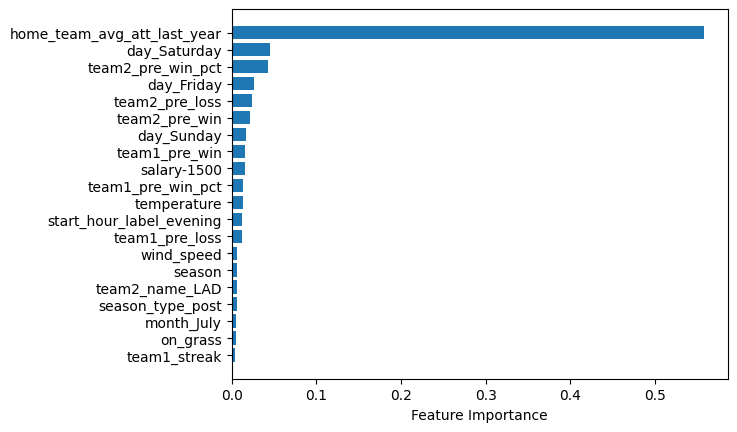

In [17]:
from matplotlib import pyplot as plt
num_features = 20
sorted_idx = gb.feature_importances_.argsort()[::-1][:num_features]
cols = data_train.columns
plt.barh(cols[sorted_idx][:num_features][::-1], gb.feature_importances_[sorted_idx][:num_features][::-1])
plt.xlabel("Feature Importance")

In [18]:
gb.feature_importances_[sorted_idx][:10]

array([0.5581806 , 0.04483451, 0.04228635, 0.02606131, 0.02419045,
       0.02158806, 0.01661786, 0.01593472, 0.01576468, 0.01304233])

## Testing set

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
y_pred = gb.predict(x_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, y_pred))

Test MSE: 42649578.538466014
Test RMSE: 6530.66447909139
Test MAE: 5008.6528265873985
Test MAPE: 0.24601368659992595


## Save model

In [20]:
import pickle
from datetime import datetime
time = datetime.today().strftime('%Y%m%d_%H%M%S')
filename = f'./model/gradientboosting_model_{time}.sav'
cv_filename = f'./model/gradientboosting_model_{time}_cv.csv'
df_res.to_csv(cv_filename, index=False)
pickle.dump(gb, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))